In [1]:
import os
from pathlib import Path
from typing import List, Dict

import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-yyy4pnnl because the default path (/home/wlchen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Functions for data processing

In [2]:
# Read patient data with from csv file
def read_data(
    path: Path,
    initial_evidence: str
) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df['INITIAL_EVIDENCE'] == initial_evidence]    

    return df

# Preprocess data
def preprocess_data(
    df: pd.DataFrame
) -> pd.DataFrame:
    # Convert string to list
    df['EVIDENCES'] = df['EVIDENCES'].apply(ast.literal_eval)
    df['DIFFERENTIAL_DIAGNOSIS'] = df['DIFFERENTIAL_DIAGNOSIS'].apply(ast.literal_eval)
    
    # Obtain only the ddx
    df['DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB'] = df['DIFFERENTIAL_DIAGNOSIS'].apply(lambda x: [ddx[0] for ddx in x])

    return df

### Functions for plotting

In [3]:
def plot_catagorical_feature_distribution(
    df: pd.DataFrame,
    feature: str, # I.e., the column name
    save_path: Path = None
):
    plt.style.use('classic')
    plt.bar(
        df[feature].value_counts().index,
        df[feature].value_counts() / df[feature].value_counts().sum() * 100,
        color='lightgreen'
    )
    plt.xticks(rotation=90)
    plt.ylabel('Frequency (%)')
    plt.title(f'{feature} Distribution')
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()


def plot_catagorical_feature_distribution_for_each_pathology(
    df: pd.DataFrame,
    feature: str, # I.e., the column name
    top_n: int = 50,
    save_path: Path = None
):
    gb = df.groupby('PATHOLOGY')

    plt.style.use('classic')
    fig, axs = plt.subplots(
        nrows=len(gb.groups.keys()),
        ncols=1,
        sharey=True,
        figsize=(5, 125)
    )
    fig.subplots_adjust(top=0.8, hspace=3)

    for ax, pathology in zip(axs, gb.groups.keys()):
        evidence_set = Counter()
        gb.get_group(pathology)[feature].apply(lambda x: evidence_set.update({evidence: 1 for evidence in x}))
        top_n = min(top_n, len(evidence_set))

        # plot catagorical feature distribution
        ax.bar(
            [k for k, v in evidence_set.most_common(top_n)],
            np.array([v for k, v in evidence_set.most_common(top_n)]) / sum(evidence_set.values()) * 100,
            color='lightgreen'
        )

        ax.set_title(pathology, fontsize=10)
        ax.set_ylabel('Frequency (%)', fontsize=10)
        ax.yaxis.grid(True)

        ax.tick_params('x', labelrotation=90, labelsize=8)
        ax.tick_params('y', labelsize=8)
        
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

### Analysis

In [4]:
df = read_data('../ddxplus/raw-data/release_test_patients.csv', initial_evidence='toux')
df = preprocess_data(df)
df.head()

,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE,DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB
0,49,"[[Bronchite, 0.20230062181160519], [RGO, 0.179...",F,RGO,"[douleurxx, douleurxx_carac_@_lancinante_/_cho...",toux,"[Bronchite, RGO, Possible NSTEMI / STEMI, Angi..."
4,70,"[[IVRS ou virémie, 0.21257615919851483], [Poss...",F,IVRS ou virémie,"[contact, diaph, douleurxx, douleurxx_carac_@_...",toux,"[IVRS ou virémie, Possible influenza ou syndro..."
22,10,[[Possible influenza ou syndrome virémique typ...,F,Possible influenza ou syndrome virémique typique,"[diaph, douleurxx, douleurxx_carac_@_une_lourd...",toux,[Possible influenza ou syndrome virémique typi...
26,1,"[[Bronchite, 0.29070421508775757], [Otite moye...",M,Otite moyenne aigue (OMA),"[H6690, douleurxx, douleurxx_carac_@_sensible,...",toux,"[Bronchite, Otite moyenne aigue (OMA), Pneumon..."
52,77,"[[IVRS ou virémie, 0.24961180257533938], [Bron...",M,IVRS ou virémie,"[crowd, douleurxx, douleurxx_carac_@_pénible, ...",toux,"[IVRS ou virémie, Bronchite, Possible influenz..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9618 entries, 0 to 134483
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   AGE                                  9618 non-null   int64 
 1   DIFFERENTIAL_DIAGNOSIS               9618 non-null   object
 2   SEX                                  9618 non-null   object
 3   PATHOLOGY                            9618 non-null   object
 4   EVIDENCES                            9618 non-null   object
 5   INITIAL_EVIDENCE                     9618 non-null   object
 6   DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB  9618 non-null   object
dtypes: int64(1), object(6)
memory usage: 601.1+ KB


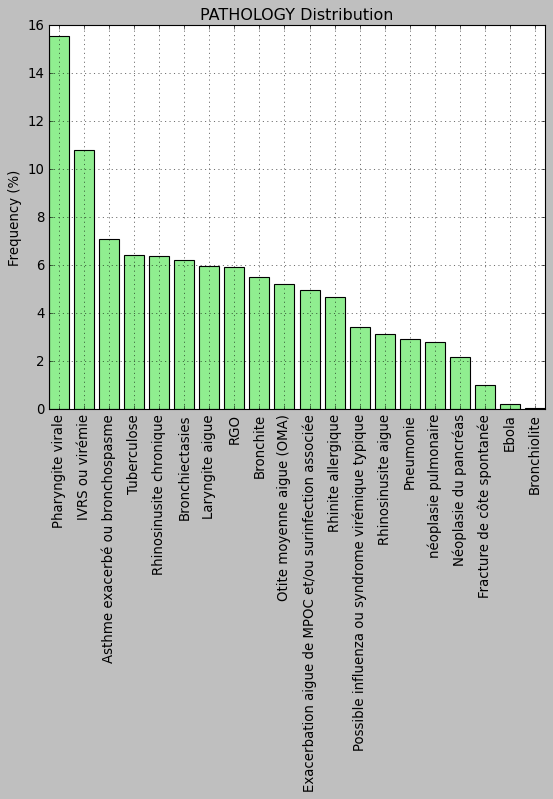

In [6]:
plot_catagorical_feature_distribution(df, feature='PATHOLOGY')

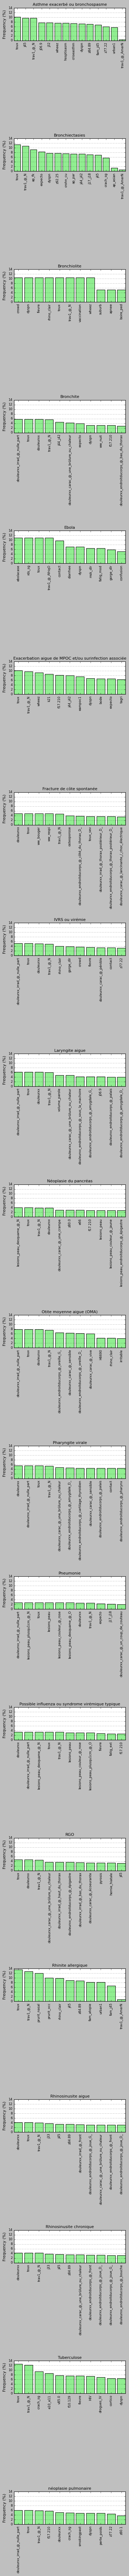

In [7]:
plot_catagorical_feature_distribution_for_each_pathology(df, feature='EVIDENCES')

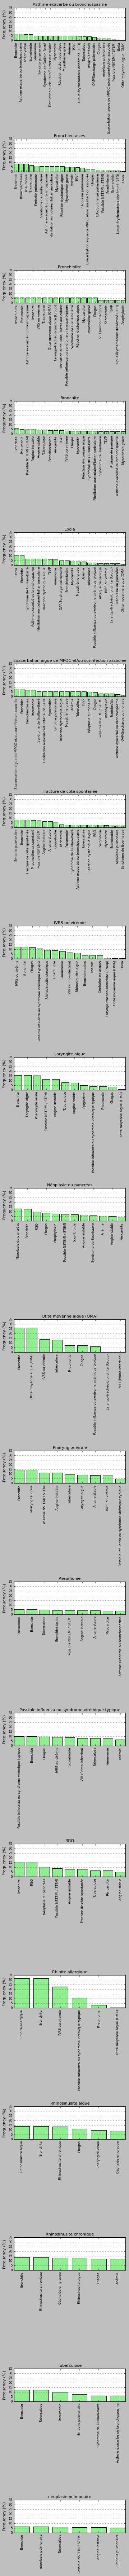

In [8]:
plot_catagorical_feature_distribution_for_each_pathology(df, feature='DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB')

In [9]:
# Generate eda report
# 
# There are threee main section:
#   1. Overview: Basic statistial information of the dataset
#   2. Variables: Detailed statistial information of each variable (i.e., column)
#   3. Interactions: In this section you can plot one variable against another for observing relatedness.
#   4. Coorelations: Observe correlatioon between variables.
#   5. Missing values: Observe missing values in the dataset.
#   6. Sample: Observe the first 10 and last 10 rows of the dataset.
#
# [ref] https://towardsdatascience.com/pandas-profiling-easy-exploratory-data-analysis-in-python-65d6d0e23650

# from pandas_profiling import ProfileReport
# report = ProfileReport(patient_testing_set_toux)
# report